# Analysis of the latent space distribution of our Variational AutoEncoder model

We analyse the latent space distribution of our model by computing the embeddings and generating new sequences. One important strength of the VAE model is its continuous and latent space distribution and therefore, its good generative ability.

In [1]:
# Import all necessary modules
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sonnia.processing import Processing
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Reshape, Activation
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from sklearn.decomposition import PCA

from keras import backend as K
import keras
from keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
from vampire_custom_keras import BetaWarmup, EmbedViaMatrix
from keras import regularizers
from keras.layers.core import Dropout

disable_eager_execution()

2023-06-10 09:58:18.988592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
df = pd.read_csv('peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df.head(5)

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
0,CASSAQGTGDRGYTF,CASSA-----QGTGDRGYTF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ01-02,ADAGFIKQY
1,CASSLVATGNTGELFF,CASSL----VATGNTGELFF,"[12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]",CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV07-09,TCRBJ02-02,ADAGFIKQY
2,CALKVGADTQYF,CALKV--------GADTQYF,"[12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]",CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV30-01,TCRBJ02-03,ADAGFIKQY
3,CASSLWASGRGGTGELFF,CASSLW--ASGRGGTGELFF,"[12, 16, 34, 34, 31, 31, 34, 27, 27, 13]",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-02,ADAGFIKQY
4,CASSLLGWEQLDEQFF,CASSL----LGWEQLDEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]",CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01,TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...,eMR16,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-01,ADAGFIKQY


In [3]:
# Keep balanced sample of the dataset
to_keep = ["FFSNVTWFH", "AFLLFLVLI", "LSPRWYFYY"]
df = df[df["Amino Acids 1"].isin(to_keep)]

In [4]:
# Encode sequences and labels 
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)

one_hot_status = True
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)
    
y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/47047 [00:00<?, ?it/s]

In [5]:
def encode_cdr3_seqs(cdr3_seqs, labelencoder, onehotencoder, onehot=True):
    """Encode CDR3 sequences to one-hot encoding."""
    encoded_seqs = []
    for cdr3 in cdr3_seqs:
        integer_encoded = labelencoder.transform(list(cdr3))
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        if onehot:
            onehot_encoded = onehotencoder.transform(integer_encoded)
            encoded_seqs.append(onehot_encoded)
        else:
            encoded_seqs.append(integer_encoded)
    return encoded_seqs

col_one_hot = encode_cdr3_seqs(df["CDR3_al"], label_encoder, onehot_encoder, onehot=True)

In [6]:
# Encode v-genes and j-genes
v_labels = []
v_encoder = LabelEncoder()
v_encoder_one_hot = OneHotEncoder(sparse=False)
v_encoder = v_encoder.fit(df['v_gene'].unique())
v_encoder_one_hot = v_encoder_one_hot.fit(v_encoder.transform(df['v_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    v_label = v_encoder.transform([df.loc[k,"v_gene"]])
    v_label = v_encoder_one_hot.transform(v_label.reshape(-1,1))
    v_labels.append(v_label)
df["v_gene_one_hot"] = v_labels

j_labels = []
j_encoder = LabelEncoder()
j_encoder_one_hot = OneHotEncoder(sparse=False)
j_encoder = j_encoder.fit(df['j_gene'].unique())
j_encoder_one_hot = j_encoder_one_hot.fit(j_encoder.transform(df['j_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    j_label = j_encoder.transform([df.loc[k,"j_gene"]])
    j_label = j_encoder_one_hot.transform(j_label.reshape(-1,1))
    j_labels.append(j_label)
df["j_gene_one_hot"] = j_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/47047 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/47047 [00:00<?, ?it/s]

In [7]:
len_j_gene = len(j_encoder.classes_)
len_v_gene = len(v_encoder.classes_)
print(len_j_gene, len_v_gene)

13 51


In [8]:
# Last pre-processing steps
df = df.sample(frac=1).reset_index(drop=True)
data = df[['CDR3_al_one_hot', 'v_gene_one_hot', 'j_gene_one_hot']]
data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))
data = [np.stack(col.values) for _, col in data.items()]
X_train = data

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3245/2658324633.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(len_v_gene,))
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_3245/2658324633.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(len_j_gene,))


In [9]:
# Define functions to build the model architecture
def build(params):

    beta = K.variable(params['beta'])

    def sampling(args):
        """
        This function draws a sample from the multivariate normal defined by
        the latent variables.
        """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(params['batch_size'], params['latent_dim']), mean=0.0, stddev=1.0)
        print(epsilon.shape)
        # Reparameterization trick!
        return (z_mean + K.exp(z_log_var / 2) * epsilon)

    def vae_cdr3_loss(io_encoder, io_decoder):
        """
        The loss function is the sum of the cross-entropy and KL divergence. KL
        gets a weight of beta.
        """
        # Here we multiply by the number of sites, so that we have a
        # total loss across the sites rather than a mean loss.
        xent_loss = params['max_cdr3_len'] * K.mean(losses.categorical_crossentropy(io_encoder, io_decoder))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss *= beta
        return (xent_loss + kl_loss)

    # Input:
    cdr3_input_shape = (params['max_cdr3_len'], params['n_aas'])
    cdr3_input = Input(shape=cdr3_input_shape, name='cdr3_input')
    v_gene_input = Input(shape=(params['n_v_genes'], ), name='v_gene_input')
    j_gene_input = Input(shape=(params['n_j_genes'], ), name='j_gene_input')

    # Encoding layers:
    cdr3_embedding = EmbedViaMatrix(params['aa_embedding_dim'], name='cdr3_embedding')(cdr3_input)
    cdr3_embedding_flat = Reshape([params['aa_embedding_dim'] * params['max_cdr3_len']],
                                  name='cdr3_embedding_flat')(cdr3_embedding)
    v_gene_embedding = Dense(params['v_gene_embedding_dim'], name='v_gene_embedding')(v_gene_input)
    j_gene_embedding = Dense(params['j_gene_embedding_dim'], name='j_gene_embedding')(j_gene_input)
    merged_embedding = keras.layers.concatenate([cdr3_embedding_flat, v_gene_embedding, j_gene_embedding],
                                                name='merged_embedding')
    encoder_dense_1 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(merged_embedding)
    encoder_dense_2 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_1)
    encoder_dense_3 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_1')(encoder_dense_2)
    encoder_dense_4 = Dense(params['dense_nodes'], activation='elu', kernel_regularizer=regularizers.l2(0.001), name='encoder_dense_2')(encoder_dense_3)
    # Latent layers:
    z_mean = Dense(params['latent_dim'], name='z_mean')(encoder_dense_2)
    z_log_var = Dense(params['latent_dim'], name='z_log_var')(encoder_dense_2)

    # Decoding layers:
    z_l = Lambda(sampling, output_shape=(params['latent_dim'], ), name='z')
    decoder_dense_1_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_1')
    decoder_dense_2_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_2')
    cdr3_post_dense_flat_l = Dense(np.array(cdr3_input_shape).prod(), activation='linear', name='cdr3_post_dense_flat')
    cdr3_post_dense_reshape_l = Reshape(cdr3_input_shape, name='cdr3_post_dense')
    cdr3_output_l = Activation(activation='softmax', name='cdr3_output')
    v_gene_output_l = Dense(params['n_v_genes'], activation='softmax', name='v_gene_output')
    j_gene_output_l = Dense(params['n_j_genes'], activation='softmax', name='j_gene_output')

    post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_l([z_mean, z_log_var])))
    cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(post_decoder)))
    v_gene_output = v_gene_output_l(post_decoder)
    j_gene_output = j_gene_output_l(post_decoder)

    # Define the decoder components separately so we can have it as its own model.
    z_mean_input = Input(shape=(params['latent_dim'], ))
    decoder_post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_mean_input))
    decoder_cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(decoder_post_decoder)))
    decoder_v_gene_output = v_gene_output_l(decoder_post_decoder)
    decoder_j_gene_output = j_gene_output_l(decoder_post_decoder)

    encoder = Model([cdr3_input, v_gene_input, j_gene_input], [z_mean, z_log_var])
    decoder = Model(z_mean_input, [decoder_cdr3_output, decoder_v_gene_output, decoder_j_gene_output])
    vae = Model([cdr3_input, v_gene_input, j_gene_input], [cdr3_output, v_gene_output, j_gene_output])
    vae.compile(
        optimizer="adam",
        loss={
            'cdr3_output': vae_cdr3_loss,
            'v_gene_output': keras.losses.categorical_crossentropy,
            'j_gene_output': keras.losses.categorical_crossentropy,
        },
        loss_weights={
            # Keep the cdr3_output weight to be 1. The weights are relative
            # anyhow, and buried inside the vae_cdr3_loss is a beta weight that
            # determines how much weight the KL loss has. If we keep this
            # weight as 1 then we can interpret beta in a straightforward way.
            "cdr3_output": 1,
            "j_gene_output": 0.1305,
            "v_gene_output": 0.8138
        })

    callbacks = [BetaWarmup(beta, params['beta'], params['warmup_period'])]

    return {'encoder': encoder, 'decoder': decoder, 'vae': vae, 'callbacks': callbacks}

In [10]:
# Set parameters for training
params = {
            "latent_dim": 2,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": len_v_gene,
            "j_gene_embedding_dim": len_j_gene,
            "beta": 0.75,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": len_v_gene,
            "n_j_genes": len_j_gene,
            "stopping_monitor": "val_loss",
            "batch_size": 50,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 4,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

In [11]:
# Build model
res = build(params)

(50, 2)


In [12]:
#keep only first 47,000 rows
X_train_2 = X_train.copy()
for i in range(len(X_train)):
    X_train_2[i] = X_train[i][:47000]

In [13]:
# Training VAE model
history = res["vae"].fit(X_train_2, X_train_2, epochs=50, batch_size=50, verbose=1, validation_split=0.2, callbacks=res["callbacks"]) 

Train on 37600 samples, validate on 9400 samples


2023-06-10 10:00:41.971570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 10:00:42.000372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/50
37400/37600 [============================>.] - ETA: 0s - loss: 16.8503 - cdr3_output_loss: 15.0938 - v_gene_output_loss: 1.7552 - j_gene_output_loss: 1.1344

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


37600/37600 [==============================] - 2s 55us/sample - loss: 16.8303 - cdr3_output_loss: 15.0752 - v_gene_output_loss: 1.7538 - j_gene_output_loss: 1.1334 - val_loss: 13.6596 - val_cdr3_output_loss: 12.1740 - val_v_gene_output_loss: 1.4660 - val_j_gene_output_loss: 1.0013
Epoch 2/50
37600/37600 [==============================] - 2s 47us/sample - loss: 10.7856 - cdr3_output_loss: 9.3952 - v_gene_output_loss: 1.3601 - j_gene_output_loss: 0.9090 - val_loss: 10.1145 - val_cdr3_output_loss: 8.7848 - val_v_gene_output_loss: 1.2991 - val_j_gene_output_loss: 0.8513
Epoch 3/50
37600/37600 [==============================] - 2s 46us/sample - loss: 11.3206 - cdr3_output_loss: 9.9921 - v_gene_output_loss: 1.3282 - j_gene_output_loss: 0.8468 - val_loss: 10.8947 - val_cdr3_output_loss: 9.5934 - val_v_gene_output_loss: 1.3115 - val_j_gene_output_loss: 0.7921
Epoch 4/50
37600/37600 [==============================] - 2s 47us/sample - loss: 11.8291 - cdr3_output_loss: 10.5101 - v_gene_output_los

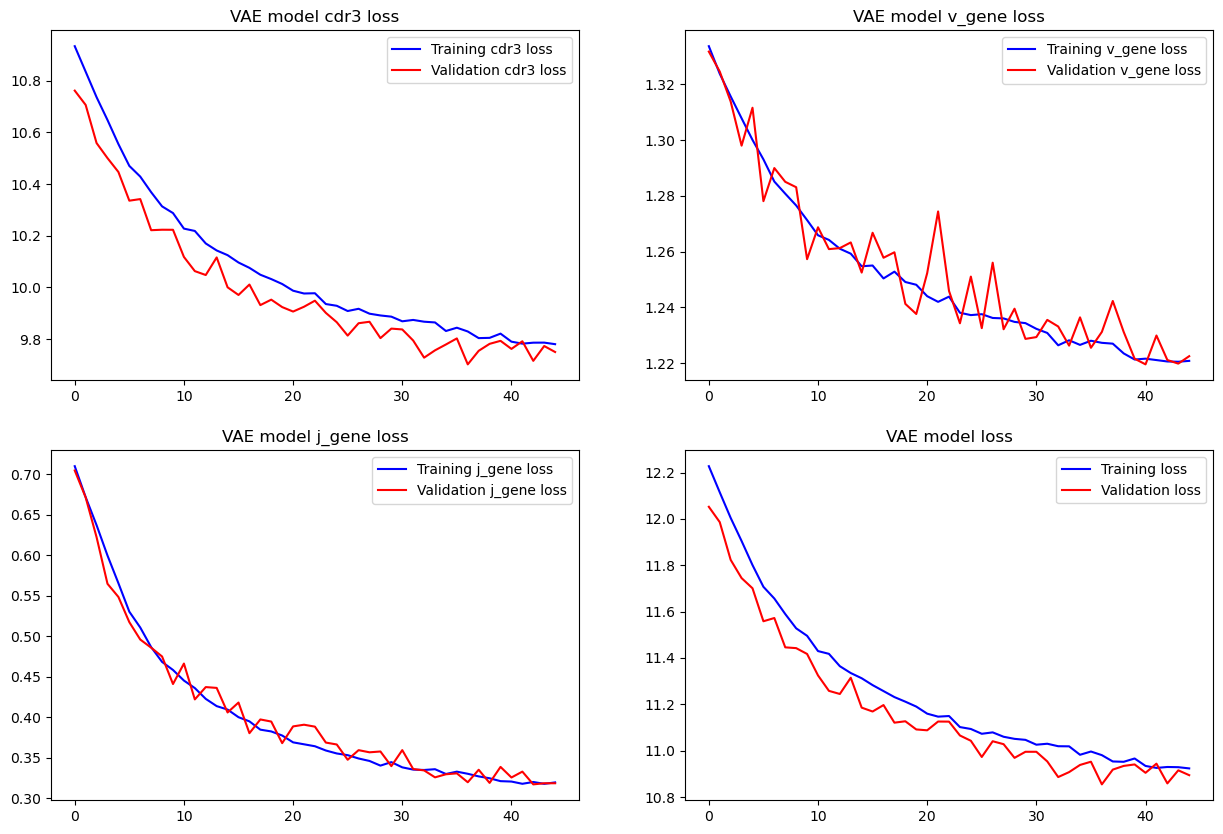

In [14]:
# Plot the history loss of the model with 4 subfigures
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['cdr3_output_loss'][5:], label='Training cdr3 loss', color='blue')
plt.plot(history.history['val_cdr3_output_loss'][5:], label='Validation cdr3 loss', color='red')
plt.title('VAE model cdr3 loss')
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(history.history['v_gene_output_loss'][5:], label='Training v_gene loss', color='blue')
plt.plot(history.history['val_v_gene_output_loss'][5:], label='Validation v_gene loss', color='red')
plt.title('VAE model v_gene loss')
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(history.history['j_gene_output_loss'][5:], label='Training j_gene loss', color='blue')
plt.plot(history.history['val_j_gene_output_loss'][5:], label='Validation j_gene loss', color='red')
plt.title('VAE model j_gene loss')
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(history.history['loss'][5:], label='Training loss', color='blue')
plt.plot(history.history['val_loss'][5:], label='Validation loss', color='red')
plt.title('VAE model loss')
plt.legend()
plt.show()

## Inspect weights (latent nodes features)

In [20]:
# Fix v_gene and j_gene
v_gene_input = np.zeros((1, 51))
j_gene_input = np.zeros((1, 13))

In [22]:
# Inspect weights interpretation
encoder = res["encoder"]
decoder = res["decoder"]

store_dict = {}

for letter in aa:
    base_seq = "-" * 20
    for pos in range(20):
        test_seq_str = base_seq[:pos] + letter + base_seq[pos+1:]
        test_seq = encode_cdr3_seqs([test_seq_str], label_encoder, onehot_encoder)
        model_input = [test_seq, v_gene_input, j_gene_input]
        model_input[0] = np.array(model_input[0])
        model_input[1] = model_input[1].reshape(1, 51)
        model_input[2] = model_input[2].reshape(1, 13)
        z_mean, z_log_var = encoder.predict(model_input)
        store_dict[test_seq_str] = z_mean

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [23]:
store_dict
# unnatural sequences -> exisitng sequence and change each letter to another letter (for different base sequences)

{'A-------------------': array([[-0.04251851, -0.07995893]], dtype=float32),
 '-A------------------': array([[ 0.01172497, -0.24340558]], dtype=float32),
 '--A-----------------': array([[-0.21529084, -0.15792784]], dtype=float32),
 '---A----------------': array([[-0.22978802, -0.20205748]], dtype=float32),
 '----A---------------': array([[-0.1884261, -0.154924 ]], dtype=float32),
 '-----A--------------': array([[-0.43059573,  0.0720991 ]], dtype=float32),
 '------A-------------': array([[-0.1003366 ,  0.17050874]], dtype=float32),
 '-------A------------': array([[-0.19179009,  0.1644978 ]], dtype=float32),
 '--------A-----------': array([[-0.44626042,  0.15044186]], dtype=float32),
 '---------A----------': array([[-6.5214932e-05,  1.4733434e-02]], dtype=float32),
 '----------A---------': array([[ 1.2928284, -0.7001935]], dtype=float32),
 '-----------A--------': array([[-0.02773002, -0.53937405]], dtype=float32),
 '------------A-------': array([[0.5667089, 0.4477082]], dtype=float32),
 

In [24]:
store_dict['A-------------------'][0][0]

-0.04251851

In [25]:
# Get most influential letter for each position
vars_pos = {}
for pos in range(20):
    print("Position:", pos)
    pos_list_1 = []
    pos_list_2 = []
    for letter in aa:
        print(letter, store_dict["-" * pos + letter + "-" * (19 - pos)])
        pos_list_1.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][0])
        pos_list_2.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][1])

    print("Variance of means latent 1:", np.var(pos_list_1))
    print("Variance of means latent 2:", np.var(pos_list_2))
    vars_pos[pos] = [np.var(pos_list_1), np.var(pos_list_2)]

Position: 0
A [[-0.04251851 -0.07995893]]
C [[-0.05980705 -0.07783613]]
D [[-0.06043563 -0.07696941]]
E [[-0.05647404 -0.07794988]]
F [[-0.05390972 -0.07862596]]
G [[-0.05007878 -0.07828657]]
H [[-0.05413431 -0.07864583]]
I [[-0.05152199 -0.07889771]]
K [[-0.04374792 -0.07776256]]
L [[-0.05379548 -0.07921298]]
M [[-0.05744398 -0.07913647]]
N [[-0.04580109 -0.07907997]]
P [[-0.0574934  -0.07833244]]
Q [[-0.05397404 -0.07819267]]
R [[-0.05073311 -0.07815847]]
S [[-0.05765171 -0.07803422]]
T [[-0.05718409 -0.07971014]]
V [[-0.044003   -0.07974432]]
W [[-0.05126078 -0.07886703]]
Y [[-0.0590599 -0.0775191]]
- [[-0.06485234 -0.07732648]]
Variance of means latent 1: 3.3947057e-05
Variance of means latent 2: 6.2804145e-07
Position: 1
A [[ 0.01172497 -0.24340558]]
C [[-0.17607526 -0.11132638]]
D [[-0.14887737 -0.13296196]]
E [[-0.23616223 -0.13872844]]
F [[-0.2125647  -0.13892019]]
G [[-0.13901393 -0.1630784 ]]
H [[-0.14807215 -0.12202063]]
I [[-0.19213851 -0.14406025]]
K [[-0.15071839 -0.17147

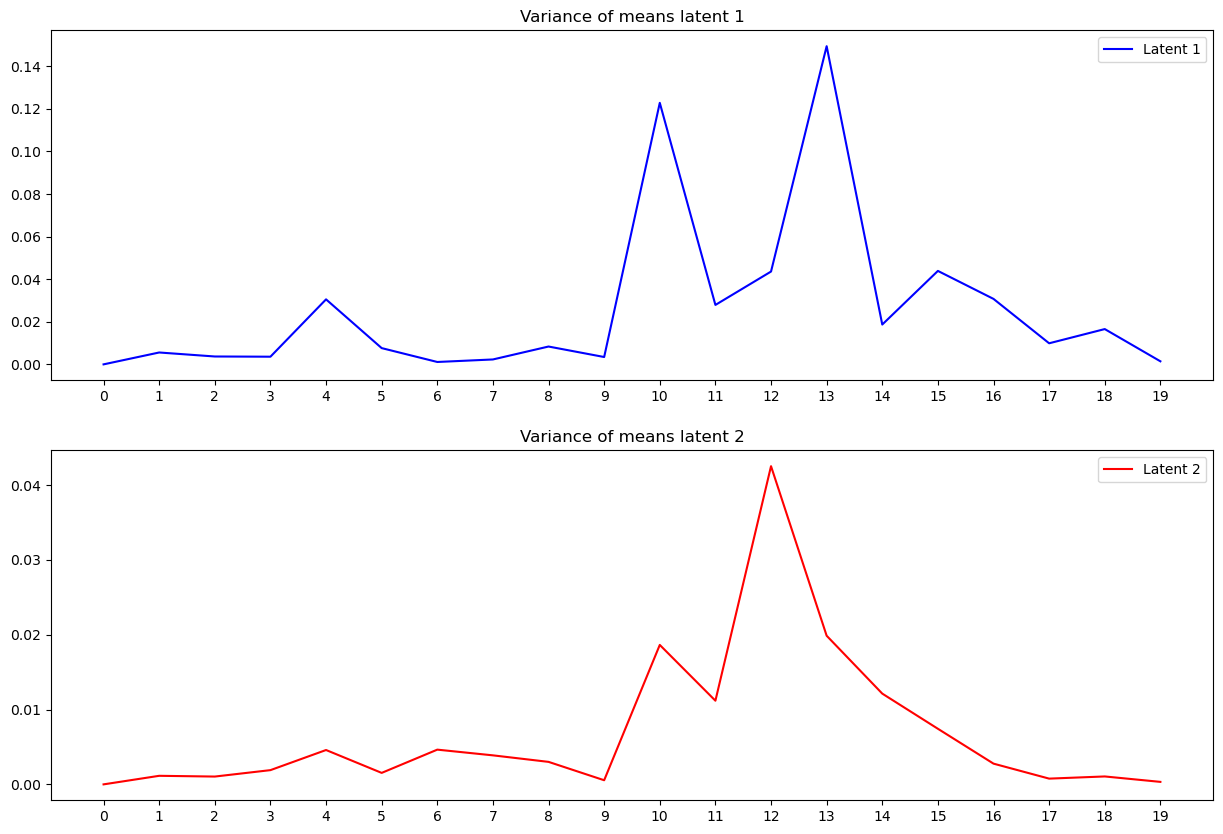

In [26]:
# Plot the variance of the means for each position
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(list(vars_pos.keys()), [vars_pos[i][0] for i in vars_pos.keys()], label='Latent 1', color='blue')
plt.title('Variance of means latent 1')
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(list(vars_pos.keys()), [vars_pos[i][1] for i in vars_pos.keys()], label='Latent 2', color='red')
plt.title('Variance of means latent 2')
plt.xticks(np.arange(0, 20, 1))
plt.legend()
plt.show()

In [81]:
import matplotlib
import matplotlib.cm as cm

# Map values to colors from blue to green as latent 1 increases
minima = min([vars_pos[i][0] for i in vars_pos.keys()])
maxima = max([vars_pos[i][0] for i in vars_pos.keys()])
my_norm_lat1 = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(0.5, 1, len([vars_pos[i][0] for i in vars_pos.keys()])))
cmap_lat1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", colors)

# Map values to colors from green to red as latent 2 increases
minima = min([vars_pos[i][1] for i in vars_pos.keys()])
maxima = max([vars_pos[i][1] for i in vars_pos.keys()])
my_norm_lat2 = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(0.5, 1, len([vars_pos[i][1] for i in vars_pos.keys()])))
cmap_lat2 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap2", colors)


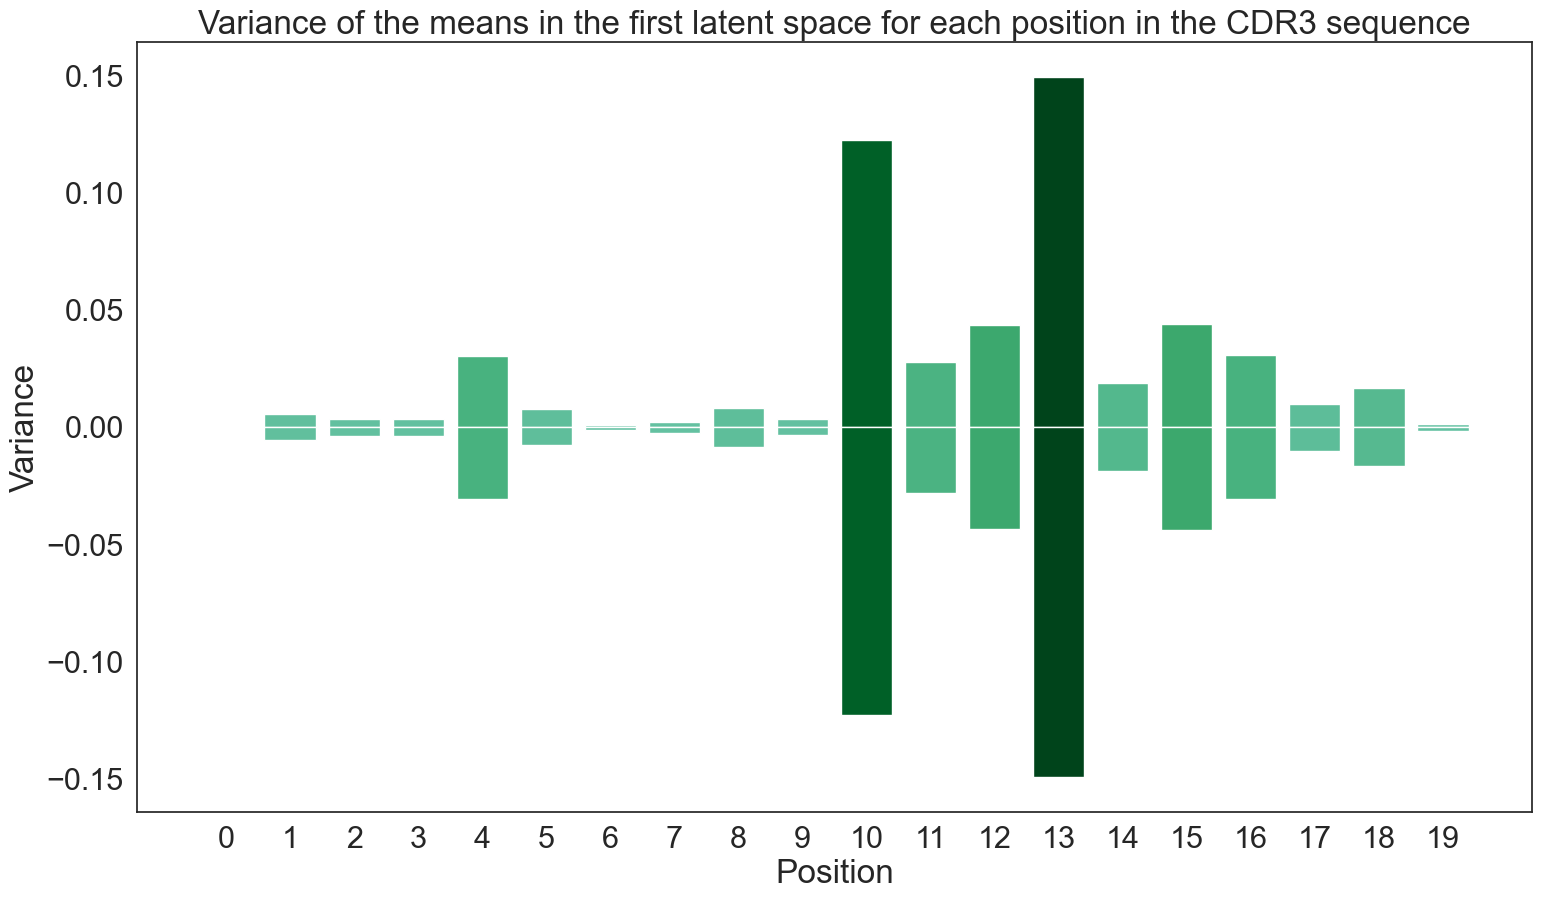

In [97]:
# Back to back bar chart in two figures with positive and negative values (symmetric around 0)
sns.set(rc={'figure.figsize':(18,10)}, font_scale=2, style="white", palette="bright")
plt.figure(figsize=(18, 10))
plt.bar(list(vars_pos.keys()), [vars_pos[i][0] for i in vars_pos.keys()], color=cmap_lat1(my_norm_lat1([vars_pos[i][0] for i in vars_pos.keys()])))
plt.bar(list(vars_pos.keys()), [-vars_pos[i][0] for i in vars_pos.keys()], color=cmap_lat1(my_norm_lat1([vars_pos[i][0] for i in vars_pos.keys()])))
plt.title('Variance of the means in the first latent space for each position in the CDR3 sequence')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel("Position")
plt.ylabel("Variance")
plt.savefig("./images/vae_var_position1.png", dpi=300, bbox_inches='tight')
plt.show()


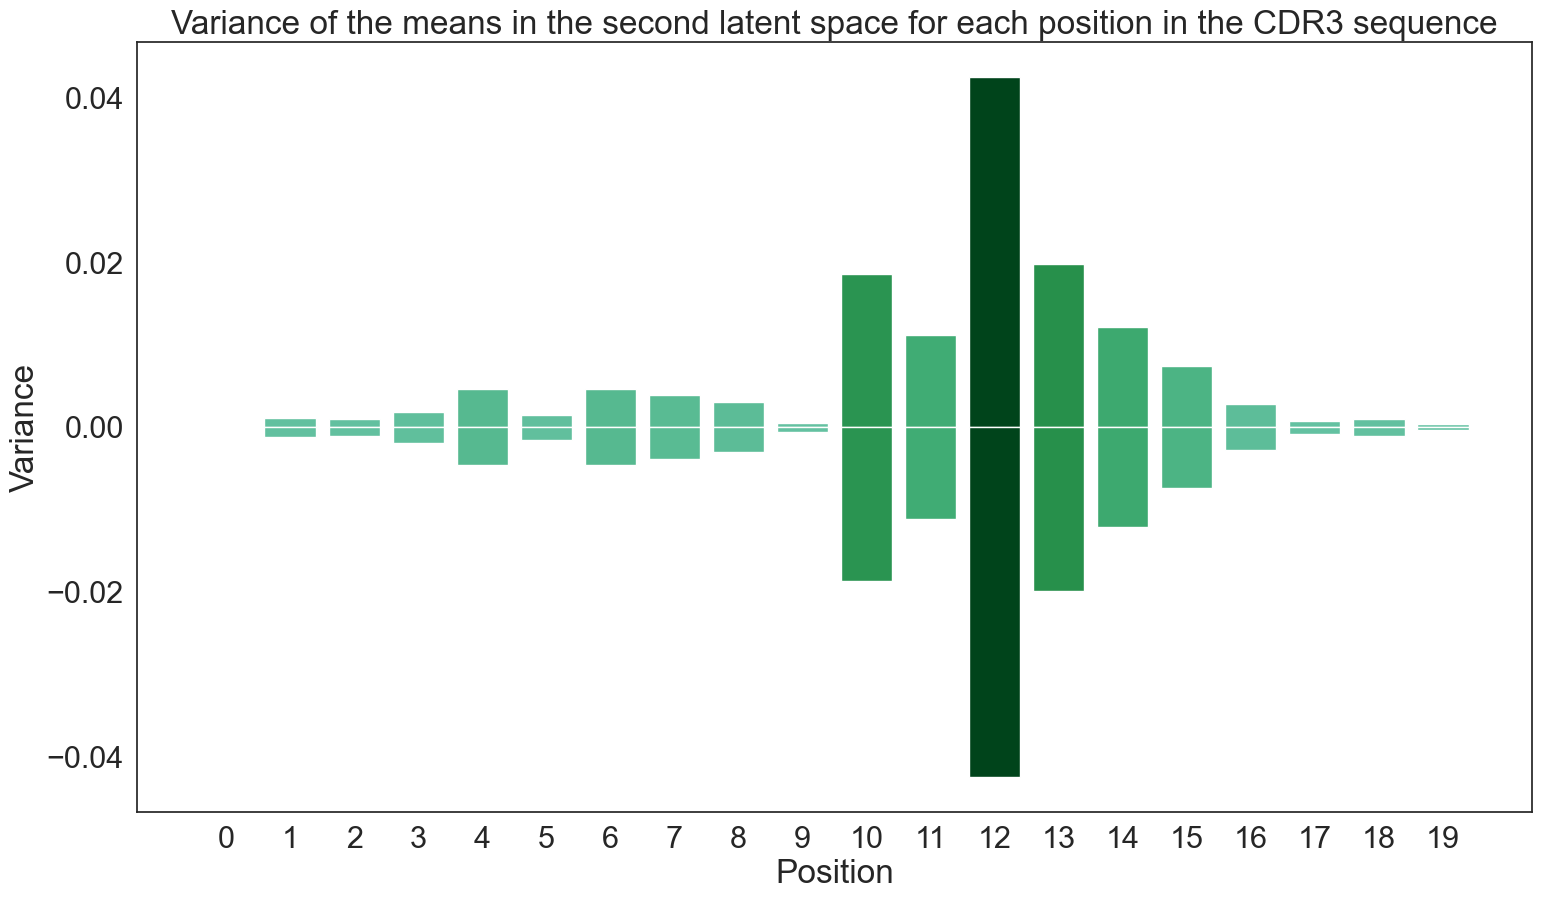

In [98]:
sns.set(rc={'figure.figsize':(18,10)}, font_scale=2, style="white", palette="bright")
plt.figure(figsize=(18, 10))
plt.bar(list(vars_pos.keys()), [vars_pos[i][1] for i in vars_pos.keys()], color=cmap_lat2(my_norm_lat2([vars_pos[i][1] for i in vars_pos.keys()])))
plt.bar(list(vars_pos.keys()), [-vars_pos[i][1] for i in vars_pos.keys()], color=cmap_lat2(my_norm_lat2([vars_pos[i][1] for i in vars_pos.keys()])))
plt.title('Variance of the means in the second latent space for each position in the CDR3 sequence')
plt.xticks(np.arange(0, 20, 1))
plt.xlabel("Position")
plt.ylabel("Variance")
plt.savefig("./images/vae_var_position2.png", dpi=300, bbox_inches='tight')
plt.show()

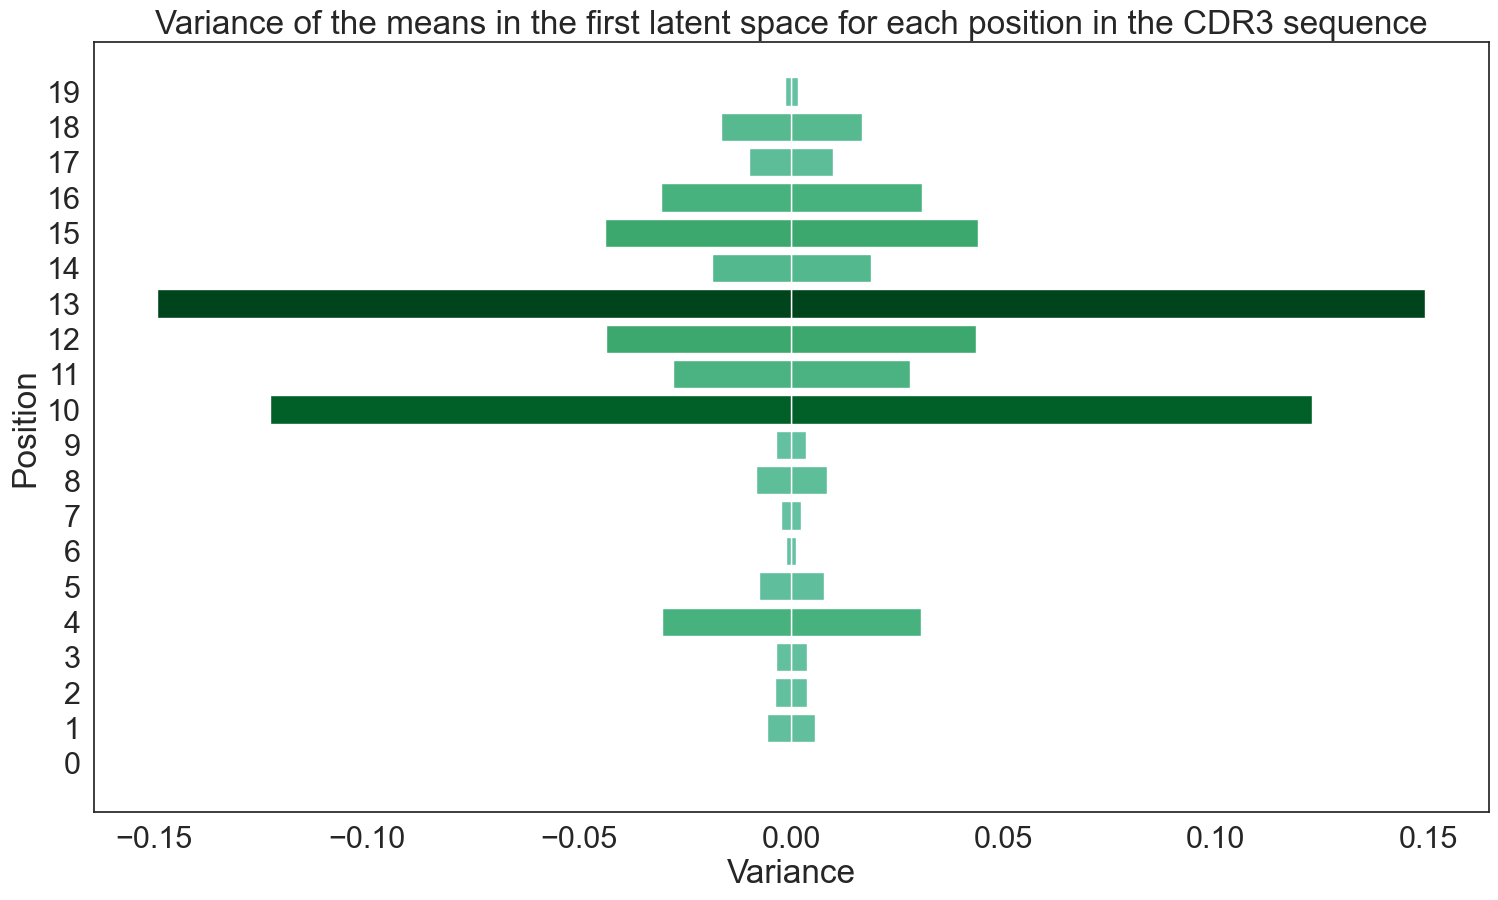

In [99]:
# Produce the same plot but turn by 90 degrees
sns.set(rc={'figure.figsize':(18,10)}, font_scale=2, style="white", palette="bright")
plt.figure(figsize=(18, 10))
plt.barh(list(vars_pos.keys()), [vars_pos[i][0] for i in vars_pos.keys()], color=cmap_lat1(my_norm_lat1([vars_pos[i][0] for i in vars_pos.keys()])))
plt.barh(list(vars_pos.keys()), [-vars_pos[i][0] for i in vars_pos.keys()], color=cmap_lat1(my_norm_lat1([vars_pos[i][0] for i in vars_pos.keys()])))
plt.title('Variance of the means in the first latent space for each position in the CDR3 sequence')
plt.yticks(np.arange(0, 20, 1))
plt.ylabel("Position")
plt.xlabel("Variance")
plt.savefig("./images/vae_var_position1_reversed.png", dpi=300, bbox_inches='tight')
plt.show()

In [27]:
list(df["CDR3_al"].unique())

['CASSA----RLAGGPNEQFF',
 'CASSL-----GGNSNQPQHF',
 'CASSI-------RSSYEQYF',
 'CASSP-----GDFMGETQYF',
 'CSVEG--------SSNEQFF',
 'CASSL-----LAGGHNEQFF',
 'CASSE------FFGTHEQYF',
 'CSASS------ESSYNEQFF',
 'CASSL-------AGAYEQYF',
 'CASRQN--NADRVTNEKLFF',
 'CASSI-----WTDDTGELFF',
 'CASSL----RDRANTGELFF',
 'CASSL------GGESTEAFF',
 'CSGET---------SAEQFF',
 'CSARS---------SYEQYF',
 'CASSL-------SLSYEQYF',
 'CASSL--------GGYEQYF',
 'CASSLY---GPGSSYNEQFF',
 'CASSL--------AGSEQYF',
 'CASRG-----LASSTDTQYF',
 'CASSL-------HPGSEQYF',
 'CASSL-----GRASSYEQYF',
 'CASSQD---PSGTANEKLFF',
 'CASSL--------AGVGYTF',
 'CASSL-------HPGVEQFF',
 'CASSQ-------LAPDTQYF',
 'CASSE------GTSGNEQFF',
 'CASSP-----LVGGPAGYTF',
 'CASL----------RLEQYF',
 'CATRP-------IREETQYF',
 'CASSL----LTSGRYNEQFF',
 'CASSE------GQGNTEAFF',
 'CATVT------GVLQETQYF',
 'CASSFL---GTSGGIDIQYF',
 'CASSG-------GWTTEAFF',
 'CASSLG--FSNRGSYNEQFF',
 'CASTTW--VAGVARPYEQYF',
 'CASSL-------QAPHEQYF',
 'CAGRQ----GQAFRVDEQYF',
 'CASSI-------RSAYEQYF',


In [28]:
# Print full value counts of CDR3s
df["CDR3_al"].value_counts()

CASSI-------RSSYEQYF    13224
CASSL-------AGAYEQYF     7735
CASSI-------RSAYEQYF     1260
CASSL-----SYRGNTEAFF      361
CASSL--------AGVGYTF      289
                        ...  
CASSE-----LPSGTDTQYF        1
CASSSIIGQGGTGGPHEQYF        1
CASSP----IAGALYNEQFF        1
CAISE-----FRQGRNEQFF        1
CASSLT--GTEDQGYYEQYF        1
Name: CDR3_al, Length: 15115, dtype: int64

In [29]:
# Get most influential letter for each position
for pos in range(20):
    print("Position:", pos)
    pos_list_1 = []
    pos_list_2 = []
    for letter in aa:
        pos_list_1.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][0])
        pos_list_2.append(store_dict["-" * pos + letter + "-" * (19 - pos)][0][1])
    print("Highest abs value letter for latent 1: ", aa[np.argmax(np.abs(pos_list_1))])
    print("Highest abs value letter for latent 2: ", aa[np.argmax(np.abs(pos_list_2))])

Position: 0
Highest abs value letter for latent 1:  -
Highest abs value letter for latent 2:  A
Position: 1
Highest abs value letter for latent 1:  S
Highest abs value letter for latent 2:  A
Position: 2
Highest abs value letter for latent 1:  V
Highest abs value letter for latent 2:  T
Position: 3
Highest abs value letter for latent 1:  P
Highest abs value letter for latent 2:  R
Position: 4
Highest abs value letter for latent 1:  I
Highest abs value letter for latent 2:  P
Position: 5
Highest abs value letter for latent 1:  D
Highest abs value letter for latent 2:  G
Position: 6
Highest abs value letter for latent 1:  G
Highest abs value letter for latent 2:  G
Position: 7
Highest abs value letter for latent 1:  R
Highest abs value letter for latent 2:  S
Position: 8
Highest abs value letter for latent 1:  G
Highest abs value letter for latent 2:  G
Position: 9
Highest abs value letter for latent 1:  D
Highest abs value letter for latent 2:  -
Position: 10
Highest abs value letter fo